In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
from tqdm import tqdm
import random
plt.style.use('ggplot')
import pickle
from sklearn import tree
from sklearn.tree import export_graphviz
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.impute import SimpleImputer
from scipy import interpolate
from scipy.interpolate import interp1d


In [2]:
MAX_DEPTH=6
NUMESTIMATORS=2

In [3]:
def getAuc(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit,class_weight='balanced'),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        #print(X_test,y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        if VERBOSE:
            print(auc)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    hull = ConvexHull(points)
    x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    return auc,CLASSIFIERS


def saveFIG(filename='tmp.pdf',AXIS=False):
    '''
        save fig for publication
    '''
    import pylab as plt
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    if not AXIS:
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(filename,dpi=300, bbox_inches = 'tight',
                pad_inches = 0,transparent=False) 
    return

In [4]:
def getacc(c1,c2,p1,p2,p3,f1,f2):
    s1=f1(1-c1)
    s2=f2(1-c2)
    A=(c1*c2*(1-p1)*(1-p2))/((c1*(1-p1)+(1-s1)*p1)*(c2*(1-p2)+(1-s2)*p2))
    B=(1-s1)*p1 - (1-c1)*(1-p1) + (1-s2)*p2 - (1-c2)*(1-p2) + p3
    return s1*p1+s2*p2+ A*B

In [5]:
def getCoverage(model,verbose=True):
    '''
        return how many distinct items (questions)
        are used in the model set.
        This includes the set of questions being
        covered by all forms that may be 
        generated by the model set
    '''
    FS=[]
    for m in model:
        for count in range(len(m.estimators_)):
            clf=m.estimators_[count]
            fs=clf.tree_.feature[clf.tree_.feature>0]
            FS=np.array(list(set(np.append(FS,fs))))
    if verbose:
        print("Number of items used: ", FS.size)
    return FS

def getConfusion(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,CONFUSION={},VERBOSE=False, USE_ONLY=None,target_names = None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators,class_weight='balanced',
                                       max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators,class_weight='balanced',
                                     max_depth=max_depth,min_samples_split=minsplit),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        print(y_test,y_pred)
        cmat=confusion_matrix(y_test, y_pred)
        acc=accuracy_score(y_test, y_pred)
        
        CONFUSION[clf]=cmat
        
        if VERBOSE:
            print(classification_report(y_test, y_pred, target_names=target_names))
            print('Confusion MAtrix:\n', cmat)
            print(' ')
            print('Accuracy:', acc)

        
    return CONFUSION,acc,y_test,y_pred

In [6]:
def getFmap(CLFstar,X,y):
    auc_=[]
    ROC={}
    fpr_ = np.linspace(0, 1, num=20, endpoint=True)
    for run in np.arange(1000):
        clf=CLFstar
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        y_pred=clf.predict_proba(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        f = interp1d(fpr, tpr)
        auc_=np.append(auc_,metrics.auc(fpr_, f(fpr_)))
        ROC[metrics.auc(fpr, tpr)]={'fpr':fpr_,'tpr':f(fpr_)}

    TPR=[]
    for a in ROC.keys():
        TPR=np.append(TPR,ROC[a]['tpr'])
    TPR=TPR.reshape(int(len(TPR)/len(fpr_)),len(fpr_))
    medTPR=np.median(TPR,axis=0)
    return interpolate.interp1d(fpr_,np.median(TPR,axis=0) ), ROC

In [89]:
xf=pd.read_csv('./2022summer/adeptphase2/Cognition.csv',index_col=0)
xf.index.name='subject_id'
xf=xf.drop('DX',axis=1)
xf.head()

,Age,Sex,BSNIP1vs2,Psychosis,BACS_COMP_Z_within,BACS_Verb_Mem_within_imputed,BACS_Dig_Seq_z_within_imputed,BACS_Tok_Mot_z_within_imputed,BACS_Verb_Flu_z_within_imputed,BACS_Sym_Cod_z_within_imputed,BACS_Tower_z_within_imputed,ConsensusWRAT,Pro_NoGap_within_Impute_Age_Sex_adjusted,Pro_Gap_within_Impute_Age_Sex_adjusted,Pro_Overlap_within_Impute_Age_Sex_adjusted,Anti_Corr_Lat_within_Impute_Age_Sex_adjusted,Anti_Error_Lat_within_Impute_Age_Sex_adjusted,Anti_prop_error_within_Impute_Age_Sex_adjusted,SSGoDiff_standwithin,SSTProportionError_standwithin
subject_id,,,,,,,,,,,,,,,,,,,,
1,21.0,1.0,1,1,-1.966352,-1.239086,-1.894718,-1.975991,-2.157289,-1.777237,-2.668861,103.0,1.29400,1.250300,1.365000,1.49310,1.84340,0.17735,-0.086522,-0.908397
4,19.0,1.0,1,1,0.387837,1.314364,1.215812,0.743739,-1.473370,0.030376,-0.117295,125.0,-0.81433,-0.067136,-0.717420,-0.16308,-0.45067,0.75196,0.406882,-0.055350
17,27.0,2.0,1,1,-1.116494,-0.934523,-1.033015,-0.698348,-0.990980,-1.574574,0.132828,105.0,-0.79924,-1.156300,-0.846560,-1.18750,-0.90979,2.08830,-1.289105,1.082046
40,60.0,1.0,1,0,1.730613,1.099544,0.861462,2.236269,0.325097,2.180177,0.990692,126.0,-0.22708,0.110990,0.099724,-1.02700,-0.69790,-1.07770,NaN,NaN
50,48.0,1.0,1,0,-0.177776,-1.113056,-0.643202,-0.058674,0.809957,-0.374233,0.313604,80.0,-0.39351,-0.492320,-1.364300,NaN,NaN,NaN,-0.654831,-0.410787


In [90]:
df=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
df=df.join(xf)#.head()

In [91]:
#df=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
df=df.drop('project',axis=1)
df.head()

,Biotype,panss_p1,panss_p2,panss_p3,panss_p4,panss_p5,panss_p6,panss_p7,panss_n1,panss_n2,...,BACS_Tower_z_within_imputed,ConsensusWRAT,Pro_NoGap_within_Impute_Age_Sex_adjusted,Pro_Gap_within_Impute_Age_Sex_adjusted,Pro_Overlap_within_Impute_Age_Sex_adjusted,Anti_Corr_Lat_within_Impute_Age_Sex_adjusted,Anti_Error_Lat_within_Impute_Age_Sex_adjusted,Anti_prop_error_within_Impute_Age_Sex_adjusted,SSGoDiff_standwithin,SSTProportionError_standwithin
subject_id,,,,,,,,,,,,,,,,,,,,,
1,2,4.0,3.0,4.0,1.0,3.0,2.0,1.0,4.0,3.0,...,-2.668861,103.0,1.29400,1.250300,1.365000,1.49310,1.84340,0.177350,-0.086522,-0.908397
4,3,3.0,1.0,3.0,1.0,2.0,2.0,1.0,3.0,4.0,...,-0.117295,125.0,-0.81433,-0.067136,-0.717420,-0.16308,-0.45067,0.751960,0.406882,-0.055350
17,2,2.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,...,0.132828,105.0,-0.79924,-1.156300,-0.846560,-1.18750,-0.90979,2.088300,-1.289105,1.082046
53,2,4.0,3.0,5.0,2.0,1.0,3.0,1.0,5.0,1.0,...,-1.243126,84.0,0.71209,1.625000,1.195700,3.12500,0.18100,0.029824,-1.082237,1.224220
73,2,6.0,5.0,6.0,4.0,5.0,6.0,6.0,1.0,4.0,...,-0.077277,93.0,-1.70400,-1.294200,-0.096217,0.25845,-1.65310,0.617100,-2.243046,2.645965


In [92]:
feature_names=df.columns
feature_names=feature_names[1:]
feature_names

Index(['panss_p1', 'panss_p2', 'panss_p3', 'panss_p4', 'panss_p5', 'panss_p6',
       'panss_p7', 'panss_n1', 'panss_n2', 'panss_n3', 'panss_n4', 'panss_n5',
       'panss_n6', 'panss_n7', 'panss_g1', 'panss_g2', 'panss_g3', 'panss_g4',
       'panss_g5', 'panss_g6', 'panss_g7', 'panss_g8', 'panss_g9', 'panss_g10',
       'panss_g11', 'panss_g12', 'panss_g13', 'panss_g14', 'panss_g15',
       'panss_g16', 'madrs_1', 'madrs_2', 'madrs_3', 'madrs_4', 'madrs_5',
       'madrs_6', 'madrs_7', 'madrs_8', 'madrs_9', 'madrs_10', 'young_1',
       'young_2', 'young_3', 'young_4', 'young_5', 'young_6', 'young_7',
       'young_8', 'young_9', 'young_10', 'young_11', 'sfs_setotal',
       'sfs_ictotal', 'sfs_ipcptotal', 'sfs_ipcctotal', 'sfs_retotal',
       'sfs_prototal', 'sfs_oetotal', 'Age', 'Sex', 'BSNIP1vs2', 'Psychosis',
       'BACS_COMP_Z_within', 'BACS_Verb_Mem_within_imputed',
       'BACS_Dig_Seq_z_within_imputed', 'BACS_Tok_Mot_z_within_imputed',
       'BACS_Verb_Flu_z_within_imputed

In [93]:
#df=df[df['Biotype']==3]
df=df.dropna()
df0=df
[p1,p2,p3]=(df0.Biotype.value_counts()/df0.Biotype.value_counts().sum()).values

In [94]:
df.Biotype.value_counts()
# 3 is HC

3    397
1    348
2    307
Name: Biotype, dtype: int64

In [122]:
def getRES(df0,MAX_DEPTH=6,NUMESTIMATORS=2,MODELfile='model23.mod'):
    df=df0
    X=df.iloc[:,1:].values
    y=df.Biotype.values#.astype(str)
    y=[(int(x)==2)+0 for x in y ]

    MODEL={}
    
    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarA=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f1,ROCA=getFmap(CLFstarA,X,y)
    
    MODEL[2]={'estimator':CLFstarA,'fmap':f1,'rocs':ROCA}

    #df=df0[df0.Biotype.isin([1,5])]
    df=df0
    X=df.iloc[:,1:].values
    y=df.Biotype.values#.astype(str)
    y=[(int(x)==3)+0 for x in y ]

    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarB=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f2,ROCB=getFmap(CLFstarB,X,y)
    MODEL[3]={'estimator':CLFstarB,'fmap':f2,'rocs':ROCB}

    R=[]
    for i in np.arange(.7,.99,.01):
        for j in np.arange(.7,.99,.01):
            R=np.append(R,[i,j,getacc(i,j,p1,p2,p3,f1,f2)])
    R=pd.DataFrame(R.reshape(len(R)//3,3))
    R.columns=['c1','c2','acc']
    R['s1']=f1(1-R.c1)
    R['s2']=f2(1-R.c2)


    X_test=df.values.astype(np.float32)
    L=[]

    for sample_id in np.arange(len(X_test)):
        Node_index=[]
        for i in CLFstarA.estimators_:
            threshold= i.tree_.threshold
            feature= i.tree_.feature
            node_indicator = i.tree_.decision_path(X_test)
            leaf_id = i.tree_.apply(X_test)

            node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]
            Node_index=np.append(Node_index,node_index)

        for i in CLFstarB.estimators_:
            threshold= i.tree_.threshold
            feature= i.tree_.feature
            node_indicator = i.tree_.decision_path(X_test)
            leaf_id = i.tree_.apply(X_test)

            node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]
            Node_index=np.append(Node_index,node_index)
        L=np.append(L,len(set(Node_index))-2)
    L=np.array(L)
    #print(np.mean(L),np.median(L))
    #sns.displot(L);


    RES=R.sort_values('acc',ascending=False).head(1)
    RES['nq_mean']=np.mean(L)
    RES['nq_median']=np.median(L)
    
    import dill
    with open(MODELfile, "wb") as dill_file:
        dill.dump(MODEL, dill_file)
    #dill_file.close()
    
    return RES, ROCA, ROCB, CLFstarA, CLFstarB

In [128]:
Rs,ROCa,ROCb,CLFstarA,CLFstarB=getRES(df0,MAX_DEPTH=10)
Rs

,c1,c2,acc,s1,s2,nq_mean,nq_median
744,0.94,0.94,0.852198,0.762036,0.846007,28.6673,29.0


In [130]:
! ls -lhtr | grep model*mod


-rw-rw-r--. 1 ishanu ishanu 542K Jul  5 20:34 model23.mod


In [131]:
# load model
import dill
with open('model23.mod','rb') as f:
    M=dill.load(f)

    

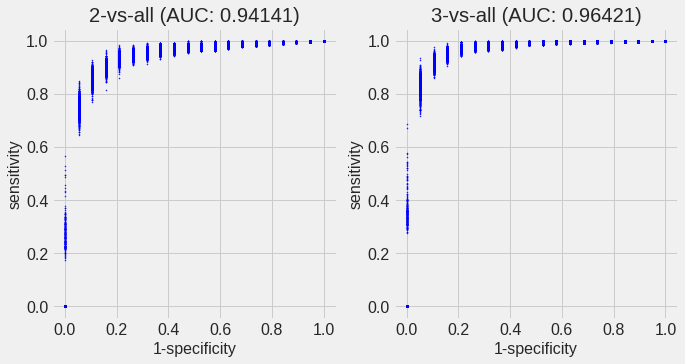

In [132]:

def pltROC(M,VAR,ax,FS=14):
    plt.style.use('fivethirtyeight')
    ROC=M[VAR]['rocs']   
    auc=[]
    for key,crv in ROC.items():
        ax.plot(crv['fpr'],crv['tpr'],'.',ms=1,color='b')
        auc=np.append(auc,key)
    ax.set_xlabel('1-specificity',fontsize=FS)
    ax.set_ylabel('sensitivity',fontsize=FS)
    plt.setp(ax.get_xticklabels(), fontsize=FS);
    plt.setp(ax.get_yticklabels(), fontsize=FS);
    ax.set_title(str(VAR)+'-vs-all (AUC: '+ str(auc.mean())[:7]+')' );
    
#plt.style.use('seaborn-whitegrid')
fig=plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
pltROC(M,2,plt.gca(),FS=16)

plt.subplot(1,2,2)
pltROC(M,3,plt.gca(),FS=16)

plt.savefig('ROC2vall_3vall_clinical_cognitive.png',dpi=400,bbox_inches='tight',transparent=True)


In [133]:
CF=np.zeros([3,3])
s2=Rs.s1.values[0]
s3=Rs.s2.values[0]
c2=Rs.c1.values[0]
c3=Rs.c2.values[0]
CF=[[c2*c3,1-c2,c2*(1-c3)],[(1-s2)*(1-s3),s2,(1-s2)*s3],[c2*(1-s3),1-c2,c2*s3]]

CF=pd.DataFrame(CF,columns=['B1','B2','B3'])
CF.index=CF.columns
CF

,B1,B2,B3
B1,0.883600,0.060000,0.056400
B2,0.036645,0.762036,0.201319
B3,0.144753,0.060000,0.795247


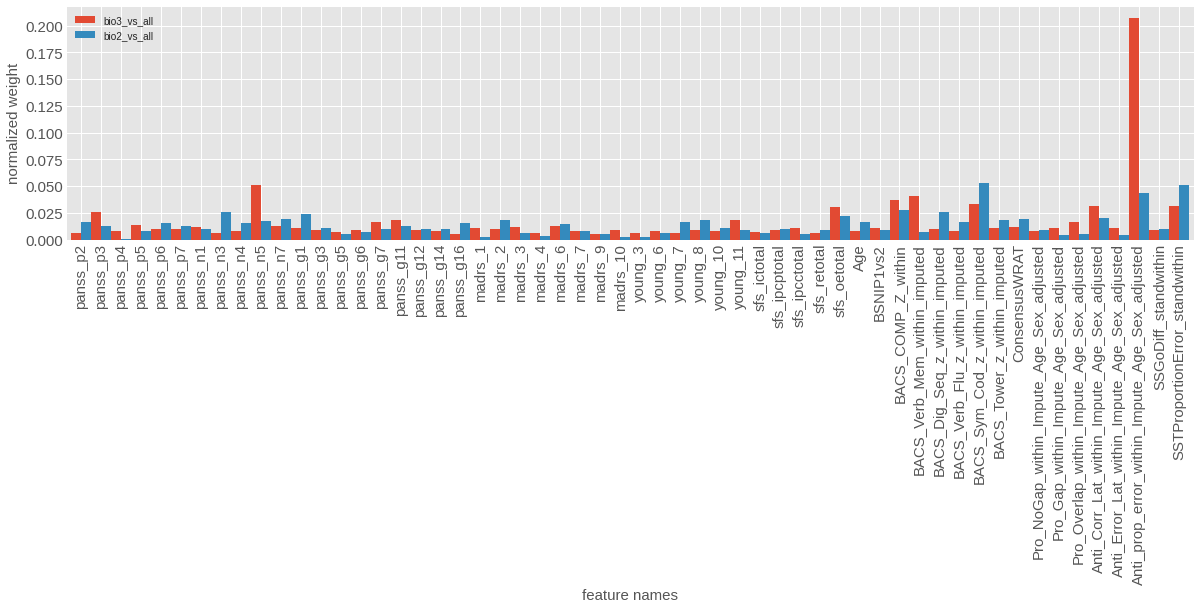

In [166]:
IMP2=M[2]['estimator'].feature_importances_
IMP3=M[3]['estimator'].feature_importances_
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
IMPdf=pd.DataFrame(IMP2,IMP3,columns=['imp_2']).reset_index()
IMPdf.columns=['bio3_vs_all','bio2_vs_all']
IMPdf.index=feature_names
plt.figure(figsize=[18,4])
ax=IMPdf[IMPdf['bio3_vs_all']>0.005].plot(kind='bar',ax=plt.gca(),width=1)
FS=15
ax.set_xlabel('feature names',fontsize=FS)
ax.set_ylabel('normalized weight',fontsize=FS)
plt.setp(ax.get_xticklabels(), fontsize=FS);
plt.setp(ax.get_yticklabels(), fontsize=FS);
#ax.set_title(str(VAR)+'-vs-all (AUC: '+ str(auc.mean())[:7]+')' );

plt.savefig('imp_small.png',dpi=400,bbox_inches='tight',transparent=True)

In [170]:
IMPdf.sort_values('bio3_vs_all',ascending=False)

,bio3_vs_all,bio2_vs_all
Anti_prop_error_within_Impute_Age_Sex_adjusted,0.207587,0.043450
panss_n5,0.050916,0.016986
BACS_Verb_Mem_within_imputed,0.040409,0.006748
BACS_COMP_Z_within,0.037001,0.027324
BACS_Sym_Cod_z_within_imputed,0.033622,0.053147
...,...,...
panss_n6,0.000000,0.016785
panss_g8,0.000000,0.008487
panss_n2,0.000000,0.005129
Psychosis,0.000000,0.000000


In [169]:
i2=IMPdf.sort_values('bio2_vs_all',ascending=False).head(10)
i3=IMPdf.sort_values('bio3_vs_all',ascending=False).head(10)
if_=pd.DataFrame({'B2_vs_all':i2.index,'B3_vs_all':i3.index})
if_.to_excel('imp.xls')

/tmp/ipykernel_656308/3762086764.py:4: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  if_.to_excel('imp.xls')


In [139]:
IMPdf.sort_values('bio_3vall',ascending=False).head(10)

,bio_3vall,bio_2vall
Anti_prop_error_within_Impute_Age_Sex_adjusted,0.207587,0.043450
panss_n5,0.050916,0.016986
BACS_Verb_Mem_within_imputed,0.040409,0.006748
BACS_COMP_Z_within,0.037001,0.027324
BACS_Sym_Cod_z_within_imputed,0.033622,0.053147
Anti_Corr_Lat_within_Impute_Age_Sex_adjusted,0.031767,0.019904
SSTProportionError_standwithin,0.031126,0.050942
sfs_oetotal,0.030792,0.021842
panss_p3,0.025667,0.012908
young_11,0.018375,0.009467


In [14]:
RES=pd.concat([pd.concat([getRES(df0,MAX_DEPTH=m) for m in tqdm(np.arange(6,12))]) for run in tqdm(range(20))])

  0%|                                                     | 0/6 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 20/20 [19:57<00:00, 59.89s/it]


In [15]:
RES

,c1,c2,acc,s1,s2,nq_mean,nq_median
444,0.84,0.94,0.688357,0.660147,0.460083,19.865970,20.0
589,0.89,0.89,0.726158,0.554013,0.746212,19.078897,19.0
709,0.93,0.89,0.764480,0.607077,0.765768,22.942966,23.0
620,0.90,0.90,0.785786,0.749043,0.746351,27.610266,28.0
743,0.94,0.93,0.827556,0.706084,0.818846,27.729087,28.0
...,...,...,...,...,...,...,...
444,0.84,0.94,0.741390,0.739680,0.589142,18.282319,19.0
619,0.90,0.89,0.788045,0.725624,0.810812,22.279468,23.0
624,0.90,0.94,0.801891,0.729295,0.744376,25.572243,26.0
742,0.94,0.92,0.816999,0.775002,0.715631,27.041825,27.0


<AxesSubplot:xlabel='nq_median'>

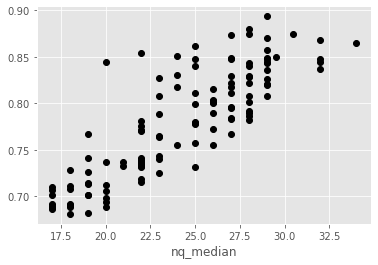

In [16]:
RES.set_index('nq_median').acc.plot(style='ko')

Text(0, 0.5, 'mean accuracy')

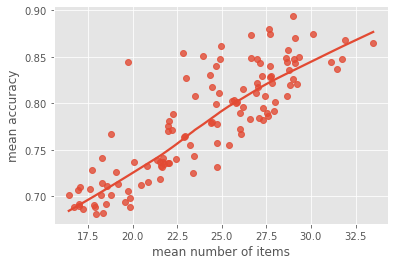

In [17]:
ax=sns.regplot(x=RES.nq_mean,y=RES.acc,ci=99.999,lowess=True)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')
#plt.savefig('accvsitemnumber.png',dpi=200,bbox_inches='tight',transparent=True)

/tmp/ipykernel_1650491/3830656434.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/3830656434.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/3830656434.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/3830656434.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/3830656434.py:21:

Text(0, 0.5, 'mean accuracy')

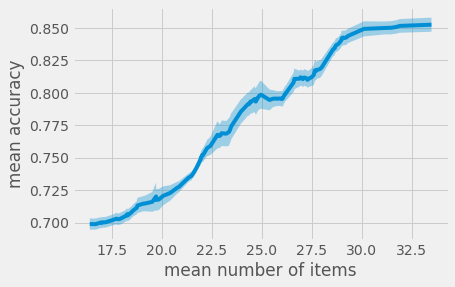

In [18]:
plt.style.use('fivethirtyeight')
df=pd.DataFrame(RES.set_index('nq_mean').acc)
import scipy.stats as stats
import statsmodels.api as sm
from scipy import interpolate
from scipy.interpolate import interp1d

lowess = sm.nonparametric.lowess
df.index=df.index.astype(float)
df=df.sort_index()
S=.2
RUNS=50
DF=df
   
for i in range(RUNS):
    X=df.sample(int(np.round(S*df.index.size))).sort_index().reset_index().values

    z = lowess(X[:,1], X[:,0], frac= .25)
    f = interp1d(z[:,0], z[:,1])
    Y=f(X[:,0])
    DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
DF=DF.interpolate(method='index',order=3,limit_direction='both')
STD=pd.DataFrame(2.62*(DF.std(axis=1)/np.sqrt(RUNS)))
Mf=pd.DataFrame(DF.mean(axis=1)).assign(sm=STD)
Mf.columns=['mn','sm']
ax=Mf.mn.plot()
plt.fill_between(Mf.index,Mf.mn-Mf.sm,Mf.mn+Mf.sm,alpha=.35)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')
#plt.savefig('accvsitemnumber1.png',dpi=200,bbox_inches='tight',transparent=True)

/tmp/ipykernel_1650491/2545937345.py:20: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/2545937345.py:20: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/2545937345.py:20: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))


Text(0, 0.5, 'mean accuracy')

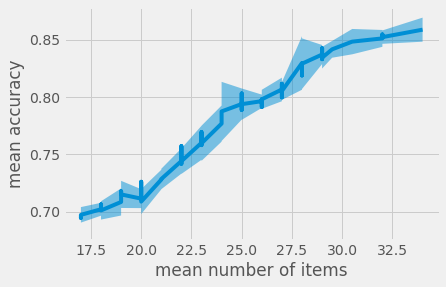

In [19]:
df=pd.DataFrame(RES.set_index('nq_median').acc)
import scipy.stats as stats
import statsmodels.api as sm
from scipy import interpolate
from scipy.interpolate import interp1d

lowess = sm.nonparametric.lowess
df.index=df.index.astype(float)
df=df.sort_index()
S=.3
RUNS=8
DF=df

for i in range(RUNS):
    X=df.sample(int(np.round(S*df.index.size))).sort_index().reset_index().values

    z = lowess(X[:,1], X[:,0], frac= .35)
    f = interp1d(z[:,0], z[:,1])
    Y=f(X[:,0])
    DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
DF=DF.interpolate(method='index',order=3,limit_direction='both')
STD=pd.DataFrame(2.62*(DF.std(axis=1)/np.sqrt(RUNS)))
Mf=pd.DataFrame(DF.mean(axis=1)).assign(sm=STD)
Mf.columns=['mn','sm']
ax=Mf.mn.plot()
plt.fill_between(Mf.index,Mf.mn-Mf.sm,Mf.mn+Mf.sm,alpha=.5)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')


In [20]:
R=RES.sort_values('acc',ascending=False)['c1','c2','acc']

KeyError: ('c1', 'c2', 'acc')

In [ ]:
R_=R.pivot(index='c2',columns='c3')
R_

In [ ]:
ax=sns.heatmap(R_)
ax.set_xlabel('c-2vall')
ax.set_ylabel('c-3vall')

In [35]:
pos=plt.imshow(R_)
plt.colorbar(pos)

NameError: name 'R_' is not defined

In [ ]:
R_=R.pivot(index='c1',columns='c2')
R_.columns=[str(x[1])[:4] for x in R_.columns]
R_.index=[str(x)[:4] for x in R_.columns]

In [ ]:
getacc(.85,.8,p1,p2,p3,f1,f2)

In [ ]:
ACC=[]
CLFh={}
for run in tqdm(np.arange(500)):
    auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
               minsplit=2,VERBOSE=False, USE_ONLY=[2])
    ACC=np.append(ACC,auc)
    if auc > 0.5:
        CLFh[auc]=CLFS
CLFstarA=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
f1=getFmap(CLFstarA)


#df=df0[df0.Biotype.isin([1,5])]
df=df0
X=df.iloc[:,2:].values
y=df.Biotype.values#.astype(str)
y=[(int(x)==3)+0 for x in y ]

ACC=[]
CLFh={}
for run in tqdm(np.arange(500)):
    auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
               minsplit=2,VERBOSE=False, USE_ONLY=[2])
    ACC=np.append(ACC,auc)
    if auc > 0.5:
        CLFh[auc]=CLFS
CLFstarB=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
f2=getFmap(CLFstarB)

In [ ]:
f2=getFmap(CLFstarB)

In [ ]:
CLFstarB=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
#F=[]
#for i in CLFstar.estimators_:
#    F=np.append(F,i.tree_.feature)
#uF=np.array(list(set(list(F[F>0]))))
#len(uF)

In [ ]:
ACC=[]
CLFh={}
for run in tqdm(np.arange(500)):
    auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
               minsplit=2,VERBOSE=False, USE_ONLY=[2])
    ACC=np.append(ACC,auc)
    if auc > 0.5:
        CLFh[auc]=CLFS
sns.distplot(ACC)
np.median(ACC)

In [ ]:
#df=df0[df0.Biotype.isin([1,5])]
df=df0
X=df.iloc[:,2:].values
y=df.Biotype.values#.astype(str)
y=[(int(x)==3)+0 for x in y ]

In [ ]:
f1=getFmap(CLFstarA)

In [ ]:
CLFstarA=CLFh[np.array([k for k in CLFh.keys()]).max()][0]